# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

**Нужно спрогнозировать**, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

**Постройте модель** с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до **0.59**. Проверьте *F1*-меру на тестовой выборке самостоятельно. Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [www.kaggle.com](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## 1. Подготовка данных

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay

### 1.1. Чтение и знакомство с данными

In [2]:
try:
    try:
        df = pd.read_csv('datasets\Churn_Modelling.csv') #домашняя версия
    except:
        df = pd.read_csv('/datasets/Churn.csv') #сетевая версия
        
    df.drop(['RowNumber'], axis=1, inplace=True) # удаляю дублирующую колонку с индексацией строк
    display(df.head())
    
except:
    print('Не удалось прочесть файл. Возможно, был указан не верный путь.')

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Признаки:**
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты 
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

**Целевой признак:**
- `Exited` — факт ухода клиента

**Вспомогательные колонки:**
- `RowNumber` — индекс строки в данных (_не используется в данной работе_)
- `CustomerId` — уникальный идентификатор клиента

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


### 1.2. Стандартизация названий колонок

In [4]:
# функция преобразования верблюжьего регистра в змеиный
def camel_to_snake(column):
    for char in column:
        if char.isupper():
            column = column.replace(char, '_' + char.lower())
    return column[1:]

In [5]:
for col in df.columns:
    new_col = camel_to_snake(col)
    df.rename(columns = {col : new_col}, inplace=True)
print(df.columns) # контроль

Index(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')


### 1.3. Определение признаков

В исходном дата фрейме не все колонки можно отнести к признакам, а именно:
- `customer_id` (_идентификатор клиента_) - это уникальное значения для каждого объекта, индексация клиентов во внутренней системе банка. Эти значения нельзя сравнить между собой, и эти значения не может напрямую охарактеризовать клиента.
- `surname` (_фамилия_) - среди клиентов могут попадаться однофамильцы, но их численность слишком мала, чтобы выстроить достоверную зависимость между фамилией и уходом клиента из банка.

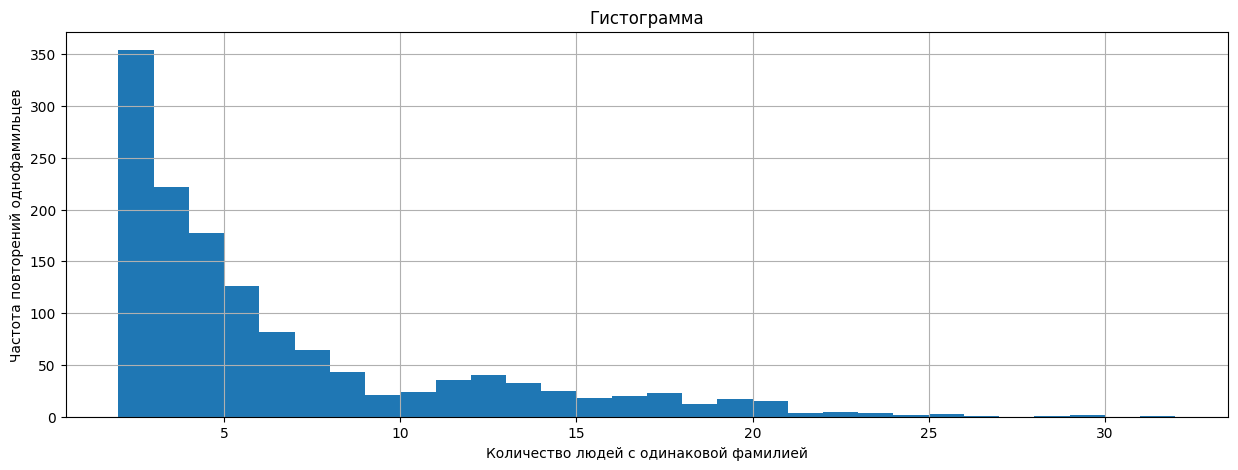

In [6]:
surname_count = df['surname'].value_counts()
surname_count[surname_count > 1].plot(kind='hist', bins=30, range=(2, 32), grid=True, figsize=(15, 5),
                                      xlabel='Количество людей с одинаковой фамилией',
                                      ylabel='Частота повторений однофамильцев',
                                      title='Гистограмма')

target = df['exited']
features = df.drop(['exited', 'customer_id', 'surname'], axis=1)

### 1.4. Валидация данных

Деление исходной выборки на 3 части:
- Тренировочная (60%);
- Валидационная (20%);
- Тестовая (20%).

Добавлена **стратификация**, позволяющая сохранить изначальное распределение классов во всех новых датасетах.

In [7]:
# выделение тренировочной выборки
features_train, features_other, target_train, target_other = train_test_split(
    features, target, train_size=0.60, stratify=target, random_state=1234)

# выделение валидационной и тестовой выборок
features_valid, features_test, target_valid, target_test = train_test_split(
    features_other, target_other, test_size=0.50, stratify=target_other, random_state=1234)

In [8]:
display(features_valid.head())
display(target_valid.to_frame().head())

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
6342,581,France,Female,37,10,104255.03,1,1,0,86609.37
7447,636,Germany,Male,30,8,141787.31,2,1,1,109685.61
8355,504,Spain,Male,44,4,113522.64,1,1,1,12405.20
355,539,France,Male,30,0,0.00,2,1,0,160979.66
3649,597,France,Male,41,4,153198.23,1,1,1,92090.36


,exited
6342,0
7447,0
8355,0
355,0
3649,0


Контроль стратификации:

In [9]:
for data, name in zip([target_train, target_valid, target_test], ['тренировочной', 'валидационной', 'тестовой']):
    print(f'Кол-во объектов {name} выборки: {data.shape[0]}, и доля от исходных данных {round(data.shape[0]/df.shape[0]*100)}%')
    display(data.value_counts(normalize=True).to_frame())

Кол-во объектов тренировочной выборки: 6000, и доля от исходных данных 60%


,proportion
exited,
0,0.796333
1,0.203667


Кол-во объектов валидационной выборки: 2000, и доля от исходных данных 20%


,proportion
exited,
0,0.7965
1,0.2035


Кол-во объектов тестовой выборки: 2000, и доля от исходных данных 20%


,proportion
exited,
0,0.796
1,0.204


### 1.5. Кодирование признаков (One-Hot Encoding)

In [10]:
features_train = pd.get_dummies(features_train, columns=['geography', 'gender'], drop_first=True)
features_valid = pd.get_dummies(features_valid, columns=['geography', 'gender'], drop_first=True)
features_test  = pd.get_dummies(features_test,  columns=['geography', 'gender'], drop_first=True)

### 1.6. Масштабирование признаков

In [11]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
for sample in [features_train, features_valid, features_test]:
    sample[numeric] = scaler.transform(sample[numeric])

**Вывод:** Название колонок приведено к единому стандарту *snake_case*, который будет использоваться далее во всём проекте. Из исходного датафрейма были убраны колонки `customer_id` и `surname` поскольку они не подходят на роль признаков. Оставшиеся данные были **закодированы** (One-Hot Encoding), **отмасштабированы** (Стандартизация данных) и **разделены** на 3 выборки: _тренировочная_, _валидационная_ и _тестовая_. Среди них выдержано одинаковое соотношение классов. Но присутствует **дисбаланс** классов, работа над которым будет произведена далее.
___


## 2. Исследование задачи

Целевой признак принимает бинарное категориальное значение: клиент ушел из банка или нет. Задача сводится к _бинарной классификации_. Для этой задачи подходят три типа моделей:
- _Логистическая регрессия_ (LR)
- _Решающее дерево_ (DT)
- _Случайный лес_ (RF)

Будут подобраны гиперпараметры, и сравнён наилучший результат предсказаний. Для обучения будут использоваться данные в первозданном виде, без внесённых изменений. Это требуется для оценки влияния дисбаланса классов.

### 2.1. Логистическая регрессия (LR)

In [12]:
best_f1 = 0
for iteration in range(10, 21, 2):  # подбор гиперпараметров модели для наивысшего качества
    model = LogisticRegression(max_iter=iteration, solver='liblinear', random_state=1234) # создание модели
    model.fit(features_train, target_train)  # обучение модели
    prediction_valid = model.predict(features_valid)  # предсказание на валидационной выборке
    f1_valid = f1_score(target_valid, prediction_valid) # оценка предсказаний
    if f1_valid > best_f1:
        best_f1 = f1_valid # фиксация лучших результатов
        best_iter = iteration # и гиперпараметров
        best_prediction_valid = prediction_valid

print('Максимальная оценка качества модели: {:.3f}, при количестве итераций: {}'.format(best_f1, best_iter))
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, best_prediction_valid),
                                                                      precision_score(target_valid, best_prediction_valid),
                                                                      roc_auc_score(target_valid, best_prediction_valid)))

Максимальная оценка качества модели: 0.329, при количестве итераций: 10
Плотность: 0.229 | Точность: 0.589 | ROC_AUC: 0.594


### 2.2. Решающее дерево (DT)

Максимальная оценка качества модели: 0.620, при глубине решающего дерева: 7
Плотность: 0.587 | Точность: 0.657 | ROC_AUC: 0.754


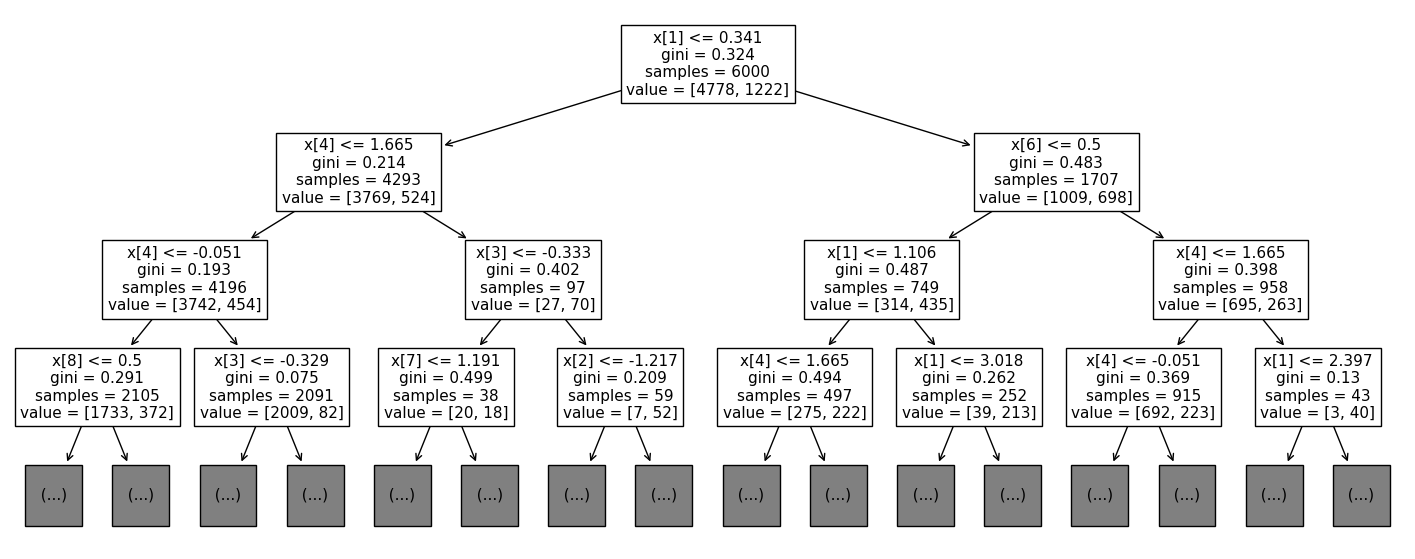

In [13]:
best_f1 = 0
best_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1234)
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)
    f1_valid = f1_score(target_valid, prediction_valid)
    if f1_valid > best_f1:
        best_f1 = f1_valid
        best_depth = depth
        best_model = model
        best_prediction_valid = prediction_valid

print('Максимальная оценка качества модели: {:.3f}, при глубине решающего дерева: {}'.format(best_f1, best_depth))
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, best_prediction_valid),
                                                                      precision_score(target_valid, best_prediction_valid),
                                                                      roc_auc_score(target_valid, best_prediction_valid)))
# визуализация решающего дерева
fig = plt.figure(figsize=(18, 7))
plot_tree(best_model, max_depth=3, fontsize=11)
plt.show()

### 2.3. Случайный лес (RF)

In [14]:
best_f1 = 0
list_f1 = []
list_est = []

for est in tqdm(range(10, 101, 10)):
    for depth in range(10, 18):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=1234)
        model.fit(features_train, target_train)
        prediction_valid = model.predict(features_valid)
        f1_valid = f1_score(target_valid, prediction_valid) 
        if f1_valid > best_f1:
            best_f1 = f1_valid
            best_dep = depth
            best_est = est
            best_prediction_valid = prediction_valid
    list_est.append(est)
    list_f1.append(best_f1)

print('Максимальная оценка модели: {:.3f}, при кол-ве деревьев: {}, и их глубине: {}'.format(best_f1, best_est, best_dep))
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, best_prediction_valid),
                                                                      precision_score(target_valid, best_prediction_valid),
                                                                      roc_auc_score(target_valid, best_prediction_valid)))

100%|██████████| 10/10 [00:35<00:00,  3.56s/it]

Максимальная оценка модели: 0.624, при кол-ве деревьев: 80, и их глубине: 15
Плотность: 0.518 | Точность: 0.784 | ROC_AUC: 0.741


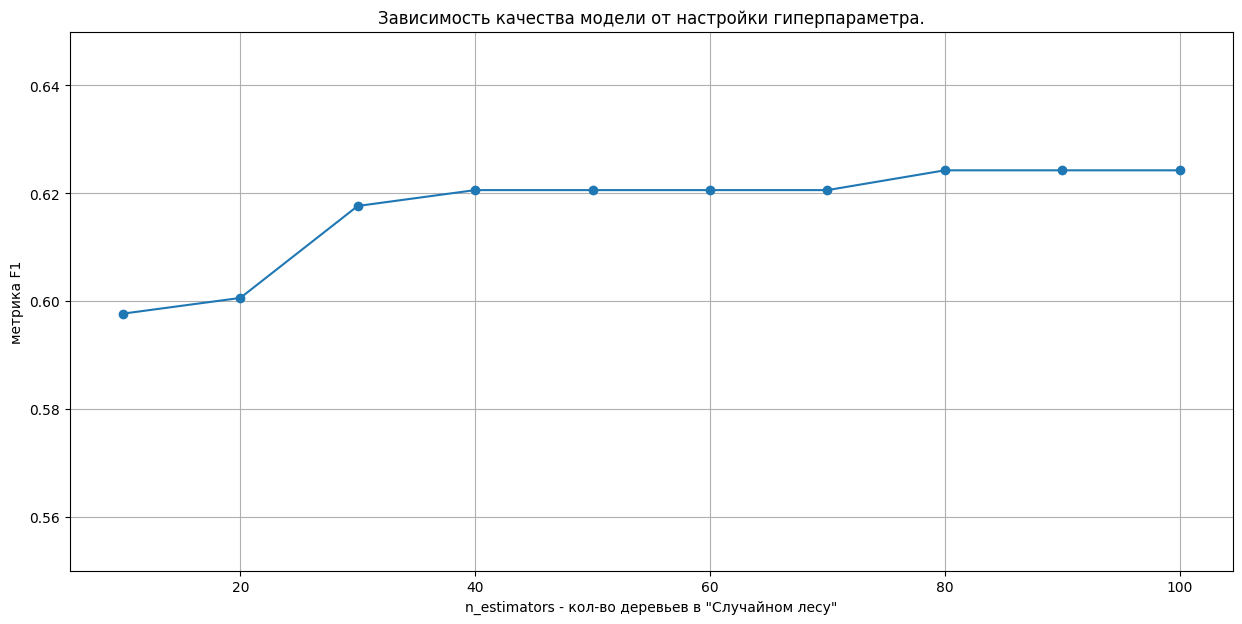

In [15]:
# Визуализация зависимости качества модели от изменения гиперпараметра
f1_score_data = pd.DataFrame({'est': list_est, 'f1_score': list_f1})
f1_score_data.plot(style='o-', x='est', y='f1_score', grid=True, legend=False, figsize=(15, 7), ylim=(0.55, 0.65),
                   title='Зависимость качества модели от настройки гиперпараметра.',
                   xlabel='n_estimators - кол-во деревьев в "Случайном лесу"',
                   ylabel='метрика F1')
plt.show()

**Вывод:** Наиболее точная модель **Случайный лес**: наилучшая F1=0.62, при максимальной глубине дерева: 15, и достаточным кол-ве деревьев: 80. Благодаря предварительно выполненной стратификации данных, модели **RF** работает достаточно быстро, несмотря на более сложную структуру работы. (проводил сравнение времени работы для обоих случаев)

**Решающее дерево** (макс. глубина = 7). Незначительное отличие по качеству предсказаний (`best_f1=0.62`), но может быть полезна для работы с бОльшими выборками, благодаря быстродействию.

**Логистическая регрессия** - самая низкокачественная в предсказания (`best_f1=0.33`).

На этом этапе подбор гиперпараметров завершен, и становится очевидной необходимость в решении проблемы дисбалансом.
___

## 3. Борьба с дисбалансом

Исходя из задания, в качестве основных метрик для оценки методов борьбы с дисбалансом будут использоваться:
- **F1_score** - показывающее условную "параллельность" _recall_ и _precision_, соотношение ложных положительных и отрицательных прогнозов.
- **ROC - кривая** - график распределения между _полнотой_ положительных ответов и их ошибками, в зависимости от порога классификации. А так же **ROC_AUC** - площадь под этим графиком.

### 3.1. Изменение веса классов

In [16]:
model = RandomForestClassifier(max_depth=best_dep, n_estimators=best_est, random_state=1234, class_weight='balanced')
model.fit(features_train, target_train)
prediction_valid = model.predict(features_valid)
f1_valid = f1_score(target_valid, prediction_valid)

print('Максимальная оценка модели: {:.3f}, при кол-ве деревьев: {}, и их глубине: {}'.format(best_f1, best_est, best_dep))
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, prediction_valid),
                                                                      precision_score(target_valid, prediction_valid),
                                                                      roc_auc_score(target_valid, prediction_valid)))

Максимальная оценка модели: 0.624, при кол-ве деревьев: 80, и их глубине: 15
Плотность: 0.521 | Точность: 0.757 | ROC_AUC: 0.739


### 3.2. Изменение порога классификации

Наивысший показатель F1 = 0.620, при смещении порога до значения 0.42


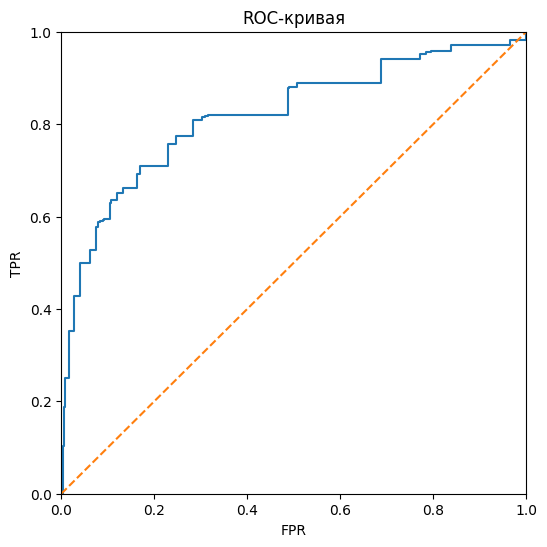

In [17]:
model = DecisionTreeClassifier(max_depth=best_depth, random_state=1234)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

best_f1 = 0
for threshold in thresholds:
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))
plt.figure(figsize = (6, 6))
plt.step(fpr, tpr, where='post')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

### 3.3. Уменьшение выборки (DownSampling)

In [18]:
# деление признаков по классам
target_train_1 = target_train[target_train == 1]
target_train_0 = target_train[target_train == 0]
features_train_1 = features_train[target_train == 1]
features_train_0 = features_train[target_train == 0]

# уменьшение выборки многочисленного класса
target_downsampled = pd.concat([target_train_0.sample(frac=0.2, random_state=1234)] + [target_train_1])
features_downsampled = pd.concat([features_train_0.sample(frac=0.2, random_state=1234)] + [features_train_1])

# перемешивание объектов внутри выборки
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=1234)

In [19]:
best_f1 = 0
list_f1 = []
list_est = []

for est in tqdm(range(10, 101, 10)):
    for depth in range(5, 16):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=1234)
        model.fit(features_downsampled, target_downsampled)
        prediction_valid = model.predict(features_valid)
        f1_valid = f1_score(target_valid, prediction_valid) 
        if f1_valid > best_f1:
            best_f1 = f1_valid
            best_dep = depth
            best_est = est
            best_prediction_valid = prediction_valid
    list_est.append(est)
    list_f1.append(best_f1)

print('Максимальная оценка модели: {:.3f}, при кол-ве деревьев: {}, и их глубине: {}'.format(best_f1, best_est, best_dep))
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, best_prediction_valid),
                                                                      precision_score(target_valid, best_prediction_valid),
                                                                      roc_auc_score(target_valid, best_prediction_valid)))

100%|██████████| 10/10 [00:19<00:00,  1.94s/it]

Максимальная оценка модели: 0.575, при кол-ве деревьев: 60, и их глубине: 12
Плотность: 0.821 | Точность: 0.443 | ROC_AUC: 0.778


### 3.4. Увеличение выборки (UpSampling)

In [20]:
# деление признаков по классам
target_train_1 = target_train[target_train == 1]
target_train_0 = target_train[target_train == 0]
features_train_1 = features_train[target_train == 1]
features_train_0 = features_train[target_train == 0]

# увеличение выборки малочисленного класса
target_upsampled = pd.concat([target_train_0] + [target_train_1] * 4)
features_upsampled = pd.concat([features_train_0] + [features_train_1] * 4)

# перемешивание объектов внутри выборки
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=1234)

In [21]:
best_f1 = 0
list_f1 = []
list_est = []

for est in tqdm(range(10, 101, 10)):
    for depth in range(10, 21):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=1234, class_weight='balanced')
        model.fit(features_upsampled, target_upsampled)
        prediction_valid = model.predict(features_valid)
        f1_valid = f1_score(target_valid, prediction_valid) 
        if f1_valid > best_f1:
            best_f1 = f1_valid
            best_dep = depth
            best_est = est
            best_prediction_valid = prediction_valid
    list_est.append(est)
    list_f1.append(best_f1)

print('Максимальная оценка модели: {:.3f}, при кол-ве деревьев: {}, и их глубине: {}'.format(best_f1, best_est, best_dep))
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, best_prediction_valid),
                                                                      precision_score(target_valid, best_prediction_valid),
                                                                      roc_auc_score(target_valid, best_prediction_valid)))

100%|██████████| 10/10 [01:13<00:00,  7.35s/it]

Максимальная оценка модели: 0.640, при кол-ве деревьев: 40, и их глубине: 15
Плотность: 0.631 | Точность: 0.649 | ROC_AUC: 0.772


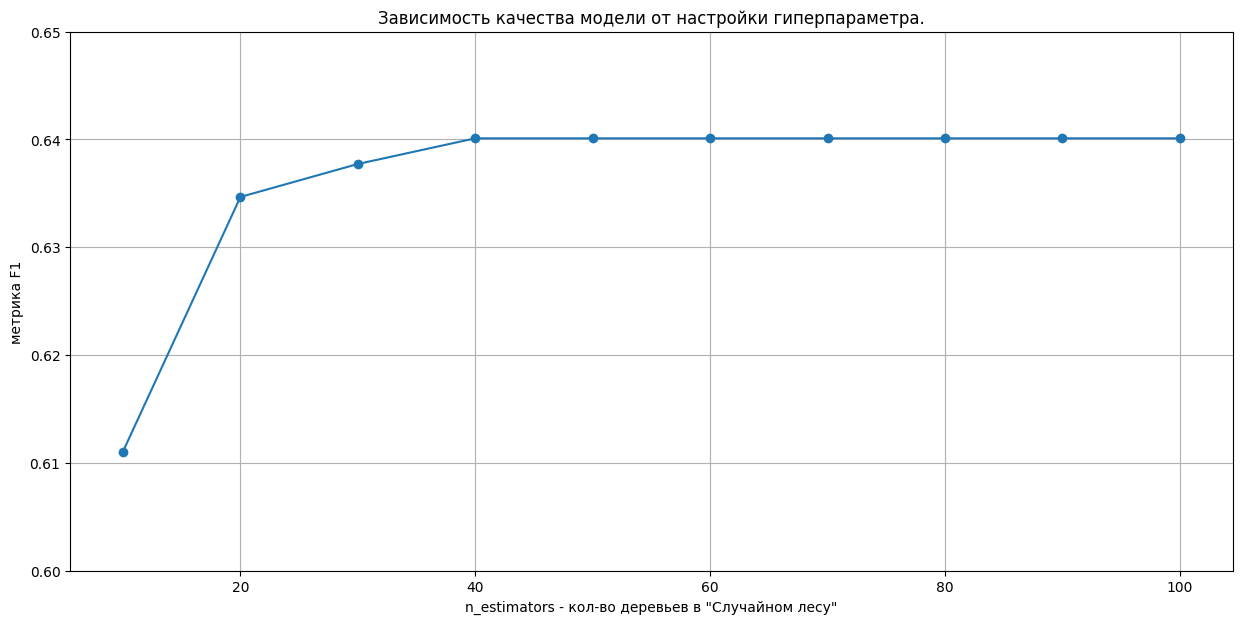

In [22]:
# Визуализация зависимости качества модели от изменения гиперпараметра.
f1_score_data = pd.DataFrame({'est': list_est, 'f1_score': list_f1})
f1_score_data.plot(style='o-', x='est', y='f1_score', grid=True, legend=False, figsize=(15, 7), ylim=(0.60, 0.65),
                   title='Зависимость качества модели от настройки гиперпараметра.',
                   xlabel='n_estimators - кол-во деревьев в "Случайном лесу"',
                   ylabel='метрика F1')
plt.show()

**Вывод:** 

Изменение **веса классов** - не повлияло на метрику _F1_.

**Изменение порога** позволило улучшить качества Логистической регрессии (`best_f1 = 0.62`), но недостаточно чтобы опередить модель Случайного леса.

**Увеличении выборки** показало наивысший результат: `best_f1 = 0.64`, в то время как уменьшение выборки - ухудшило модель.
___

## 4. Тестирование модели

Для учёта дисбаланса будет использоваться **Увеличение выборки**. Дабы уменьшить дублирование малого класса, будут использоваться объекты 1-ого класса из валидационной выборки. Таким образом получиться уменьшить кол-во синтетических объектов и связей.

In [23]:
# деление признаков по классам
target_valid_1 = target_valid[target_valid == 1]
target_train_1 = target_train[target_train == 1]
target_train_0 = target_train[target_train == 0]
features_valid_1 = features_valid[target_valid == 1]
features_train_1 = features_train[target_train == 1]
features_train_0 = features_train[target_train == 0]

# увеличение выборки малочисленного класса
target_combined = pd.concat([target_train_0] + ([target_train_1] + [target_valid_1]) * 2)
features_combined = pd.concat([features_train_0] + ([features_train_1] + [features_valid_1]) * 2)

# перемешивание объектов внутри выборки
features_combined, target_combined = shuffle(features_combined, target_combined, random_state=1234)

Максимальная оценка модели: 0.640, при кол-ве деревьев: 40, и их глубине: 15
Плотность: 0.580 | Точность: 0.665 | ROC_AUC: 0.753


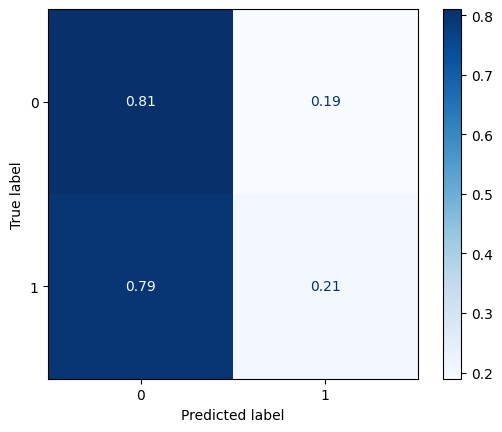

In [24]:
model = RandomForestClassifier(max_depth=best_dep, n_estimators=best_est, random_state=1234, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
prediction_test = model.predict(features_test)
f1_valid = f1_score(target_valid, prediction_valid)


print('Максимальная оценка модели: {:.3f}, при кол-ве деревьев: {}, и их глубине: {}'.format(best_f1, best_est, best_dep))
print('Плотность: {:.3f} | Точность: {:.3f} | ROC_AUC: {:.3f}'.format(recall_score(target_valid, prediction_valid),
                                                                      precision_score(target_valid, prediction_valid),
                                                                      roc_auc_score(target_valid, prediction_valid)))

ConfusionMatrixDisplay.from_estimator(model, X=features_test, y=target_valid, cmap=plt.cm.Blues, normalize='true');

**Общий вывод:**
Из исходных данных были отобраны только те значения, которые подходят в качестве признаков. Категориальные данные были закодированы с помощью **One-Hot Encodind**, а количественные были стандартизированы с помощью **StandartScaler**.

Задача подходит под тип: бинарной классификации, для выполнение которой выбраны модели: Логистическая регрессия (LR), Решающее дерево (DT) и Случайный лес (RF). Экспериментальным путём были подобраны подходящие _гиперпараметры_ для наилучшего результата предсказаний. Среди вышеупомянутых моделей выделилась модель: Случайный лес (RF).

Между классами присутствует дисбаланс. Целевой класс находится в меньшинстве: ушедших клиентов в 4 раза меньше оставшихся. Эту проблему получилось решить за счёт _Увеличении выборки_ целевого класса. Остальные метода: _уменьшение выборки_, _изменение порога классификации_ или _веса класса_ - не принесли лучших результатов.

Итоговой сборкой стала: модель **Случайный лес (RF)** с **увеличения выборки целевого класса**.

На тесте получились сравнительно такие же значения метрик, как и на валидационной выборке. По этому можно судить, что модель смогла установить связь между признаками. Гиперпараметры модели подобраны таким образом, чтобы уменьшить ложные предсказания, и не нарушить баланс между ними.

Но можно изменить баланс в пользу уменьшения ложных пропусков. Получится уменьшить число вовремя нераспознанных ушедших клиентов, но увеличится и кол-во постоянных клиентов, которые ошибочно будут получать рекламные предложения связанное с их уходом.